# Exercise 2: Glass Data (Multiclass)

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

<AxesSubplot:>

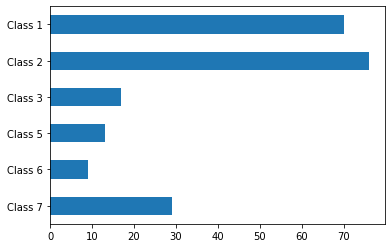

In [55]:
df = pd.read_csv('glass.csv')
df['class'].value_counts().sort_index(ascending=False).plot(kind='barh')

<AxesSubplot:>

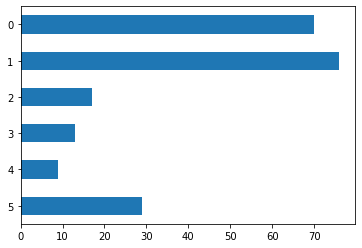

In [56]:
# Make labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['class'] = le.fit_transform(df['class'])
df['class'].value_counts().sort_index(ascending=False).plot(kind='barh')

In [57]:
colsX = [i for i in df.columns if i != 'class']
X = df[colsX].values
y = df['class'].values

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.20,
    stratify=y,
    random_state=1)

# Constructing a pipeline object
pipe_svc = Pipeline([('scl', StandardScaler()),
            ('clf', SVC(random_state=1))])

# Training
pipe_svc.fit(X_train, y_train)

# Prediction from test data
y_pred = pipe_svc.predict(X_test)

## Visualize confusion matrices

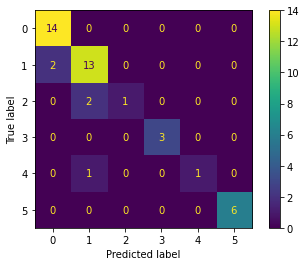

In [58]:
# Visualization
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(estimator=pipe_svc, X=X_test, y_true=y_test)  
plt.show()

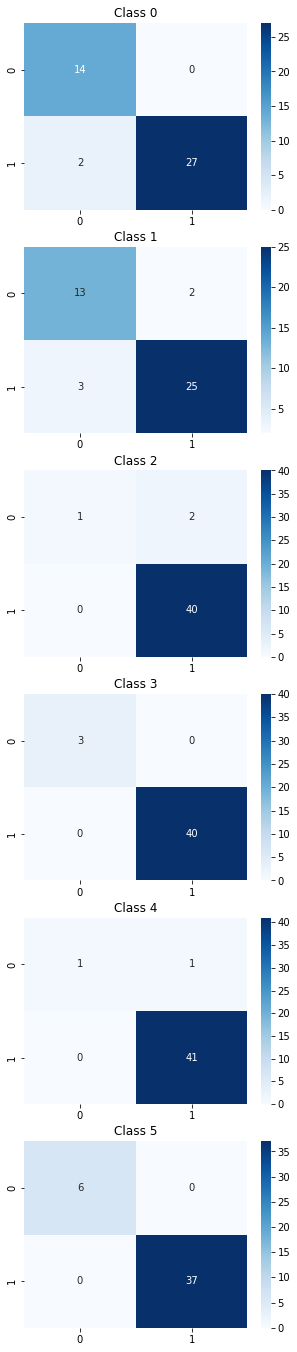

In [59]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
#Multilabel confusion matrix
matrices = multilabel_confusion_matrix(y_true=y_test, y_pred=y_pred)

nc = np.unique(y).shape[0]
fig, axs = plt.subplots(nc, 1, figsize=(5,nc*4))
for idx, m in enumerate(matrices):
    sns.heatmap(np.flip(m), annot=True, cmap='Blues', ax=axs[idx])
    axs[idx].set_title(f'Class {idx}')

# Calculate metrices

In [60]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,  digits=4))

              precision    recall  f1-score   support

           0     0.8750    1.0000    0.9333        14
           1     0.8125    0.8667    0.8387        15
           2     1.0000    0.3333    0.5000         3
           3     1.0000    1.0000    1.0000         3
           4     1.0000    0.5000    0.6667         2
           5     1.0000    1.0000    1.0000         6

    accuracy                         0.8837        43
   macro avg     0.9479    0.7833    0.8231        43
weighted avg     0.8939    0.8837    0.8716        43



In [61]:
from sklearn.metrics import precision_recall_fscore_support

arr = []
for average in ['macro', 'weighted', 'micro']:
    prfs = precision_recall_fscore_support(y_test, y_pred, average=average)
    data = {'average': average, 'precision': prfs[0], "recall": prfs[1], "f1": prfs[2] }
    arr.append(data)

dft = pd.DataFrame.from_records(arr, index='average')
display(dft)

,precision,recall,f1
average,,,
macro,0.947917,0.783333,0.823118
weighted,0.893895,0.883721,0.871643
micro,0.883721,0.883721,0.883721


## Perform gridsearch on the selected metrice

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

c_gamma_range = [0.01, 0.1, 1.0, 10.0]
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
set1 = {'clf__C': param_range, 'clf__kernel': ['linear']}
set2 = {'clf__C': param_range, 'clf__gamma': param_range, 'clf__kernel': ['rbf']}
param_grid = [set1, set2]

# Making scorer wrapper so that we can pass the desired argument.
scorer = make_scorer(recall_score, average='micro')

# Grid search.
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  # Use scorer here
                  scoring=scorer,
                  cv=5,
                  n_jobs=-1)
                  
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9356302521008402
{'clf__C': 100.0, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}


## Re-evaluate metrices

In [63]:
print(classification_report(y_test, y_pred,  digits=4))
arr = []
for average in ['macro', 'weighted', 'micro']:
    prfs = precision_recall_fscore_support(y_test, y_pred, average=average)
    data = {'average': average, 'precision': prfs[0], "recall": prfs[1], "f1": prfs[2] }
    arr.append(data)

dft = pd.DataFrame.from_records(arr, index='average')
display(dft)

              precision    recall  f1-score   support

           0     0.8750    1.0000    0.9333        14
           1     0.8125    0.8667    0.8387        15
           2     1.0000    0.3333    0.5000         3
           3     1.0000    1.0000    1.0000         3
           4     1.0000    0.5000    0.6667         2
           5     1.0000    1.0000    1.0000         6

    accuracy                         0.8837        43
   macro avg     0.9479    0.7833    0.8231        43
weighted avg     0.8939    0.8837    0.8716        43



,precision,recall,f1
average,,,
macro,0.947917,0.783333,0.823118
weighted,0.893895,0.883721,0.871643
micro,0.883721,0.883721,0.883721


## Use the `class weight` setting

In [64]:
# Constructing a pipeline object
pipe_svc_balanced = Pipeline([('scl', StandardScaler()),
            ('clf', SVC(random_state=1, class_weight='balanced'))])

# Training
pipe_svc_balanced.fit(X_train, y_train)

# Prediction from test data
y_pred = pipe_svc_balanced.predict(X_test)

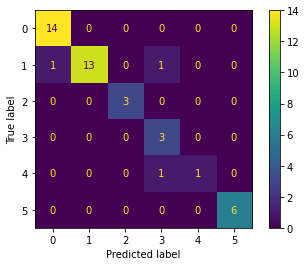

              precision    recall  f1-score   support

           0     0.9333    1.0000    0.9655        14
           1     1.0000    0.8667    0.9286        15
           2     1.0000    1.0000    1.0000         3
           3     0.6000    1.0000    0.7500         3
           4     1.0000    0.5000    0.6667         2
           5     1.0000    1.0000    1.0000         6

    accuracy                         0.9302        43
   macro avg     0.9222    0.8944    0.8851        43
weighted avg     0.9504    0.9302    0.9309        43



In [65]:
plot_confusion_matrix(estimator=pipe_svc_balanced, X=X_test, y_true=y_test)  
plt.show() 
print(classification_report(y_test, y_pred, digits=4))

## Use SMOTE 

In [66]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)
pd.Series(y_train_os).value_counts()

# Training
pipe_svc.fit(X_train_os, y_train_os)
# Prediction from test data
y_pred = pipe_svc.predict(X_test)

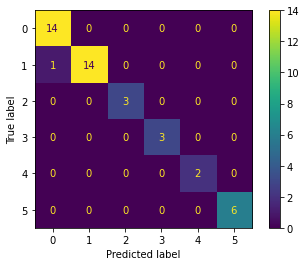

              precision    recall  f1-score   support

           0     0.9333    1.0000    0.9655        14
           1     1.0000    0.9333    0.9655        15
           2     1.0000    1.0000    1.0000         3
           3     1.0000    1.0000    1.0000         3
           4     1.0000    1.0000    1.0000         2
           5     1.0000    1.0000    1.0000         6

    accuracy                         0.9767        43
   macro avg     0.9889    0.9889    0.9885        43
weighted avg     0.9783    0.9767    0.9767        43



In [67]:
plot_confusion_matrix(estimator=pipe_svc, X=X_test, y_true=y_test)  
plt.show() 
print(classification_report(y_test, y_pred, digits=4))